# Wind from clustering

In [27]:
import pandas as pd
import numpy as np
import pickle
import os
import sqlite3
from model.op import FleetSizeOptimizer
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [4]:
params = {}

for miles in np.arange(20, 160, 10):

    centroid= pd.read_csv(f'input/icrat_wind/aircraft_params/centroids_{miles}.csv')[['hour', 'flight_time_A_B_rounded', 'energy_consumption_%_A_B', 'flight_time_B_A_rounded', 'energy_consumption_%_B_A']]
    cluster_ids = np.arange(centroid.shape[0]/24)
    centroid['cluster_id'] = np.repeat(cluster_ids, 24)

    for i in cluster_ids:
        flight_time = np.zeros((289, 2, 2))
        flight_time[1:289,0,1] = np.repeat(centroid[centroid['cluster_id'] == i]['flight_time_A_B_rounded'],12)
        flight_time[1:289,1,0] = np.repeat(centroid[centroid['cluster_id'] == i]['flight_time_B_A_rounded'],12)

        energy_consumption = np.zeros((289, 2, 2))
        energy_consumption[1:289,0,1] = np.repeat(centroid[centroid['cluster_id'] == i]['energy_consumption_%_A_B'],12)
        energy_consumption[1:289,1,0] = np.repeat(centroid[centroid['cluster_id'] == i]['energy_consumption_%_B_A'],12)

        run_id = f"dist_{miles}_cluster_{int(i)}"
        
        if run_id not in params:
            params[run_id] = {}
        params[run_id]['flight_time'] = flight_time
        params[run_id]['energy_consumption'] = energy_consumption


In [5]:
with open('input/icrat_wind/parsed_aircraft_params.pkl', 'wb') as f:
    pickle.dump(params, f)

## Zero-wind

In [45]:
zero_wind = pd.read_csv('input/icrat_wind/aircraft_params/zero_wind.csv')
zero_wind_params = {}

for index, row in zero_wind.iterrows():
    run_id = f"dist_{int(row['flight_distance'])}_cluster_99"
    if run_id not in params:
        zero_wind_params[run_id] = {}
    zero_wind_params[run_id]['flight_time'] = np.array([[0, row['flight_time']], [row['flight_time'], 0]])
    zero_wind_params[run_id]['energy_consumption'] = np.array([[0, row['energy_consumption']], [row['energy_consumption'], 0]])

In [46]:
with open('input/icrat_wind/parsed_aircraft_params_zero_wind.pkl', 'wb') as f:
    pickle.dump(zero_wind_params, f)

# Wind results with sql table

In [8]:
with open('input/icrat_wind/parsed_aircraft_params.pkl', 'rb') as f:
    params = pickle.load(f)

file_list = os.listdir('output/icrat_wind/fleet_op_result')
all_files = []
for filename in file_list:
    if filename.endswith('_op_result.txt'):
        all_files.append(filename)
file_names = np.empty(shape=(0, 4))
for i in all_files:
    file_names = np.vstack((file_names, np.array(i.split('_')[:4])))

In [16]:
conn = sqlite3.connect('wind_variation_result.sqlite')
for i in range(len(all_files)):
    # Load parameters
    run_id = all_files[i].split('_op_result.txt')[0]
    flight_time = params[run_id]['flight_time']
    energy_consumption = params[run_id]['energy_consumption']
    flight_distance = np.array([[0, file_names[i][1]], [file_names[i][1], 0]]).astype(int)

    # Call optimizer class and redner summary
    optimizer = FleetSizeOptimizer(flight_time, energy_consumption, schedule='icrat_wind/demand/schedule_500pax_5min_0206.csv')
    result_path = f'icrat_wind/fleet_op_result/{all_files[i]}'
    optimizer.parse_result(result_path)
    optimizer.calculate_aircraft_states()
    summary = optimizer.get_summary_statistics(flight_distance, return_summary=True)

    # Save summary statistics
    line_i = np.array([summary['fleet_size'], summary['pads'][0], summary['pads'][1], summary['number_of_repositioning_flights']])
    summary_statistics = pd.DataFrame(line_i.reshape(1,4), columns=['fleet_size', 'pads_at_SFO', 'pads_at_SJC', 'number_of_repositioning_flights'])
    summary_statistics['id'] = run_id
    summary_statistics.to_sql('op_summary_statistics', conn, if_exists='append', index=False)

    # Save vertisim inputs
    vertisim_input = pd.concat([optimizer.specificc, optimizer.specificn, optimizer.specificu])
    vertisim_input.reset_index(drop=True, inplace=True)
    vertisim_input['id'] = run_id
    vertisim_input.to_sql('vertisim_input', conn, if_exists='append', index=False)



Fleet size: 27.0
Total number of pads: 27; [11 16] 
Total number of flights: 428.0; demand: 374.0; repositioning: 54.0
Total energy consumption: 8774.0 kWh
Total aircraft miles: 51360.0 mi
Total revenue aircraft miles: 44880.0
Ratio of revenue aircraft miles to aircraft miles: 0.8738317757009346
Fleet size: 34.0
Total number of pads: 34; [13 21] 
Total number of flights: 426.0; demand: 374.0; repositioning: 52.0
Total energy consumption: 10215.0 kWh
Total aircraft miles: 63900.0 mi
Total revenue aircraft miles: 56100.0
Ratio of revenue aircraft miles to aircraft miles: 0.8779342723004695
Fleet size: 26.0
Total number of pads: 26; [11 15] 
Total number of flights: 428.0; demand: 374.0; repositioning: 54.0
Total energy consumption: 8535.0 kWh
Total aircraft miles: 51360.0 mi
Total revenue aircraft miles: 44880.0
Ratio of revenue aircraft miles to aircraft miles: 0.8738317757009346
Fleet size: 27.0
Total number of pads: 27; [11 16] 
Total number of flights: 428.0; demand: 374.0; repositio

In [17]:
conn = sqlite3.connect('wind_variation_result.sqlite')
query = """
SELECT *
FROM op_summary_statistics
"""
df = pd.read_sql_query(query, conn)
df

,fleet_size,pads_at_SFO,pads_at_SJC,number_of_repositioning_flights,id
0,27.0,11.0,16.0,54.0,dist_120_cluster_6
1,34.0,13.0,21.0,52.0,dist_150_cluster_7
2,26.0,11.0,15.0,54.0,dist_120_cluster_5
3,27.0,11.0,16.0,54.0,dist_110_cluster_6
4,32.0,13.0,20.0,50.0,dist_140_cluster_7
...,...,...,...,...,...
107,36.0,16.0,20.0,80.0,dist_150_cluster_4
108,14.0,6.0,11.0,34.0,dist_60_cluster_4
109,6.0,4.0,5.0,46.0,dist_20_cluster_3
110,8.0,4.0,7.0,38.0,dist_30_cluster_1


## Collect charging results

In [19]:
with open('input/icrat_wind/parsed_aircraft_params.pkl', 'rb') as f:
    params = pickle.load(f)

file_list = os.listdir('output/icrat_wind/fleet_op_result')
all_files = []
for filename in file_list:
    if filename.endswith('_op_result.txt'):
        all_files.append(filename)
file_names = np.empty(shape=(0, 4))
for i in all_files:
    file_names = np.vstack((file_names, np.array(i.split('_')[:4])))

In [21]:
soc_transition_time = np.array([0.0129,0.0133,0.0137,0.0142,0.0147,
                        0.0153,0.0158,0.0166,0.0172,0.018,
                        0.0188,0.0197,0.0207,0.0219,0.0231,
                        0.0245,0.026,0.0278,0.03,0.0323,
                        0.0351,0.0384,0.0423,0.0472,0.0536,
                        0.0617,0.0726,0.0887,0.1136,0.1582,
                        0.2622,0.9278,])*60
def calc_charging_time(start, end, soc_transition_time=soc_transition_time):
    return np.ceil(soc_transition_time[start:end].sum() / 5)*5

In [22]:
output = pd.DataFrame(columns=['distance', 'cluster', 'direction', 'charging_time'])
for i in range(len(all_files)):
    flight_time = params[all_files[i].split('_op_result.txt')[0]]['flight_time']
    energy_consumption = params[all_files[i].split('_op_result.txt')[0]]['energy_consumption']
    optimizer = FleetSizeOptimizer(flight_time, energy_consumption, schedule='icrat_wind/demand/schedule_500pax_5min_0206.csv')
    result_path = f'icrat_wind/fleet_op_result/{all_files[i]}'
    optimizer.parse_result(result_path)

    df = optimizer.specificc
    soc_change = df.apply(lambda x: calc_charging_time(x['x'], x['y']), axis=1)
    df['charging_time'] = soc_change
    # to_append = pd.DataFrame({'distance':np.repeat(file_names[i][1], df.shape[0]), 'cluster':np.repeat(file_names[i][3], df.shape[0]), 'direction':df['i'], 'charging_time':soc_change})


    total_charging_time = df.groupby(['i'])['charging_time'].sum().reset_index()['charging_time'].to_numpy()
    row = {'distance':file_names[i][1], 'cluster':file_names[i][3], 'direction':'A', 'charging_time':total_charging_time[0]}
    row2 = {'distance':file_names[i][1], 'cluster':file_names[i][3], 'direction':'B', 'charging_time':total_charging_time[1]}
    output = output.append(row, ignore_index=True)
    output = output.append(row2, ignore_index=True)


## Visualization

In [23]:
output['charging_time'] = output['charging_time'].astype(int)
output['distance'] = output['distance'].astype(int)
output2 = output.groupby(['distance', 'direction']).mean().reset_index()
output2['charging_time'] = output2['charging_time']/60

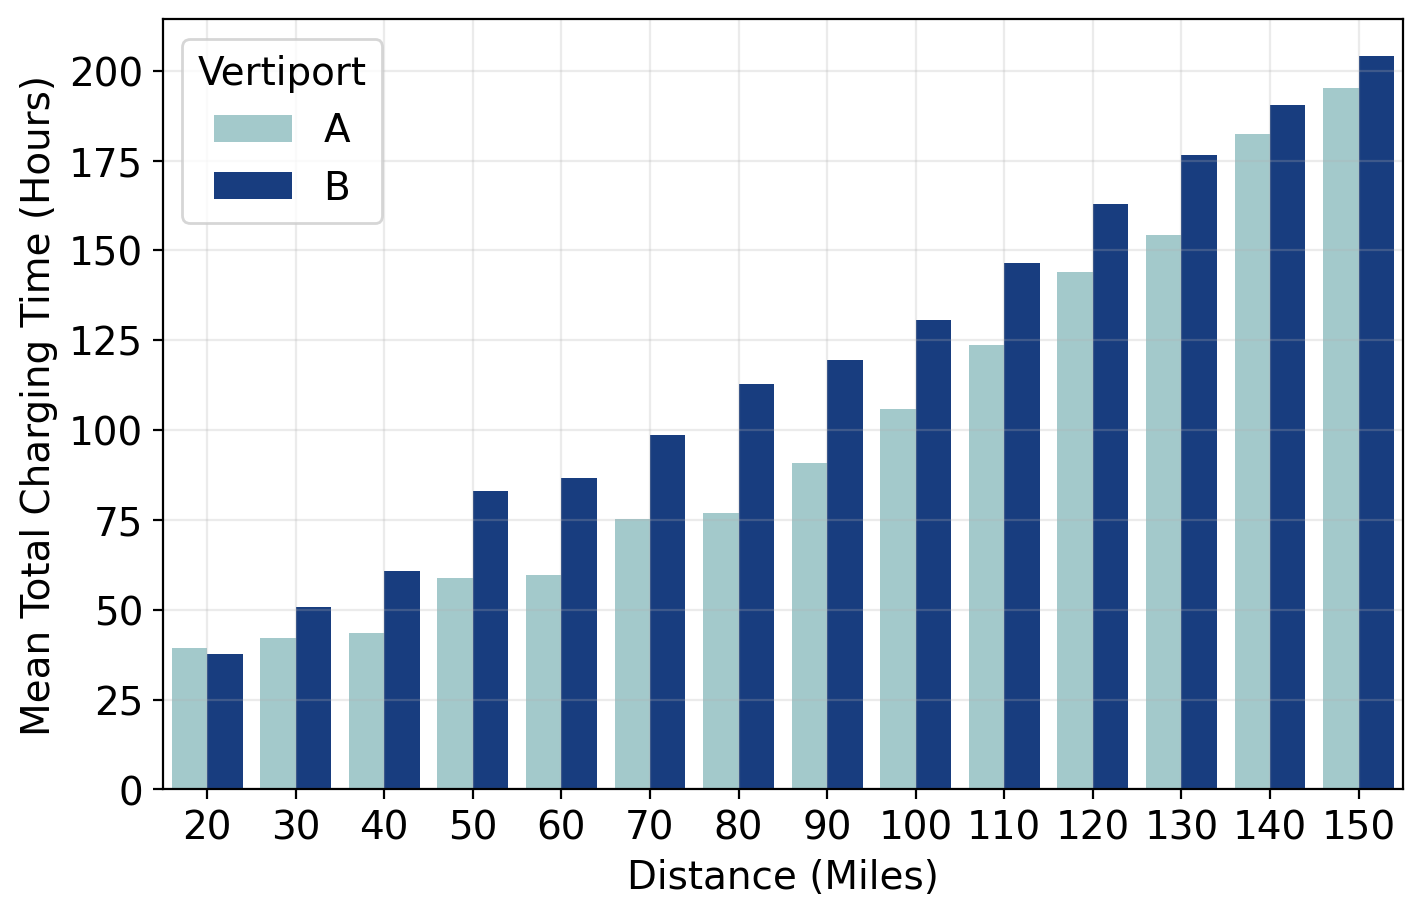

In [26]:
plt.rcParams['font.size'] = 14

fig, ax = plt.subplots(figsize=(8, 5), dpi=200)
sns.barplot(x='distance', y='charging_time', hue='direction', 
            palette=['#9ccfd2', '#073890'], data=output2, ax=ax)
ax.set(xlabel='Distance (Miles)', ylabel='Mean Total Charging Time (Hours)')
plt.legend(title='Vertiport')
plt.grid(alpha=0.25)